# Analyzing a transmon and a resonator

**Prerequisite**

A working local installation of Ansys

### Transmon & resonator: render into Ansys.
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Set up EPR junction dictionary. <br>
1. Run EPR analysis on the two modes. <br>
1. Get qubit frequency and anharmonicity. <br>
1. Render to Ansys Q3D. <br>
1. Calculate the capacitance matrix. <br>

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

In [2]:
%metal_heading Create a single transmon qubit and a resonator

### Create the design in Metal
Create a design by specifying the chip size and open Metal GUI.

In [3]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'
hfss = design.renderers.hfss

gui = MetalGUI(design)

Create a single transmon with one readout resonator. Please refer to tutorials on analyzing a transmon and analyzing a resonator if you're not familiar with the cell below.

In [4]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
readout = RouteMeander(design, 'readout',  Dict(
            total_length='6 mm',
            hfss_wire_bonds = True,
            fillet='90 um',
            lead = dict(start_straight='100um'),
            pin_inputs=Dict(
                start_pin=Dict(component='Q1', pin='readout'),
                end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

### Establish a connection between Metal and Ansys
Open Ansys. This can either be done manually, or by executing one of the lines in the following cell. <br>
open_ansys() will look by default for the 2021 R2 version of Ansys. You can easily reroute it to your Ansys of choice by providing the name of the environment variable that contains the path (path_env) or the path itself (path)

In [5]:
hfss.open_ansys()   # this opens Ansys 2021 R2 if present
# hfss.open_ansys(path_var='ANSYSEM_ROOT211')
# hfss.open_ansys(path='C:\Program Files\AnsysEM\AnsysEM21.1\Win64')
# hfss.open_ansys(path='../../../Program Files/AnsysEM/AnsysEM21.1/Win64')

If a project was not automatically opened, you can manually create/open one from the Ansys GUI. Alternatively you can execute the following cell.

In [6]:
# hfss.new_ansys_project()

Finally connect this Jupyter Notebook session with the active Ansys project.

In [7]:
hfss.connect_ansys()
# hfss.connect_ansys('C:\\project_path\\', 'Project1')  # will open a saved project before linking the Jupyter session

INFO 11:45AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:45AM [load_ansys_project]: 	Opened Ansys App
INFO 11:45AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 11:45AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project10
INFO 11:45AM [connect_design]: No active design found (or error getting active design).
INFO 11:45AM [connect]: 	 Connected to project "Project10". No design detected


### Prepare and run the analysis

Create and activate an eigenmode design called "TransmonReadout".

In [8]:
hfss.activate_eigenmode_design("TransmonReadout")

11:45AM 26s WARNING [activate_eigenmode_design]: The name=TransmonReadout was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 11:45AM [connect_design]: 	Opened active design
	Design:    TransmonReadout [Solution type: Eigenmode]
WARNING 11:45AM [connect_setup]: 	No design setup detected.
WARNING 11:45AM [connect_setup]: 	Creating eigenmode default setup.
INFO 11:45AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


Render everything inlcuding the qubit and resonator in Metal, to "TransmonReadout" design in Ansys.

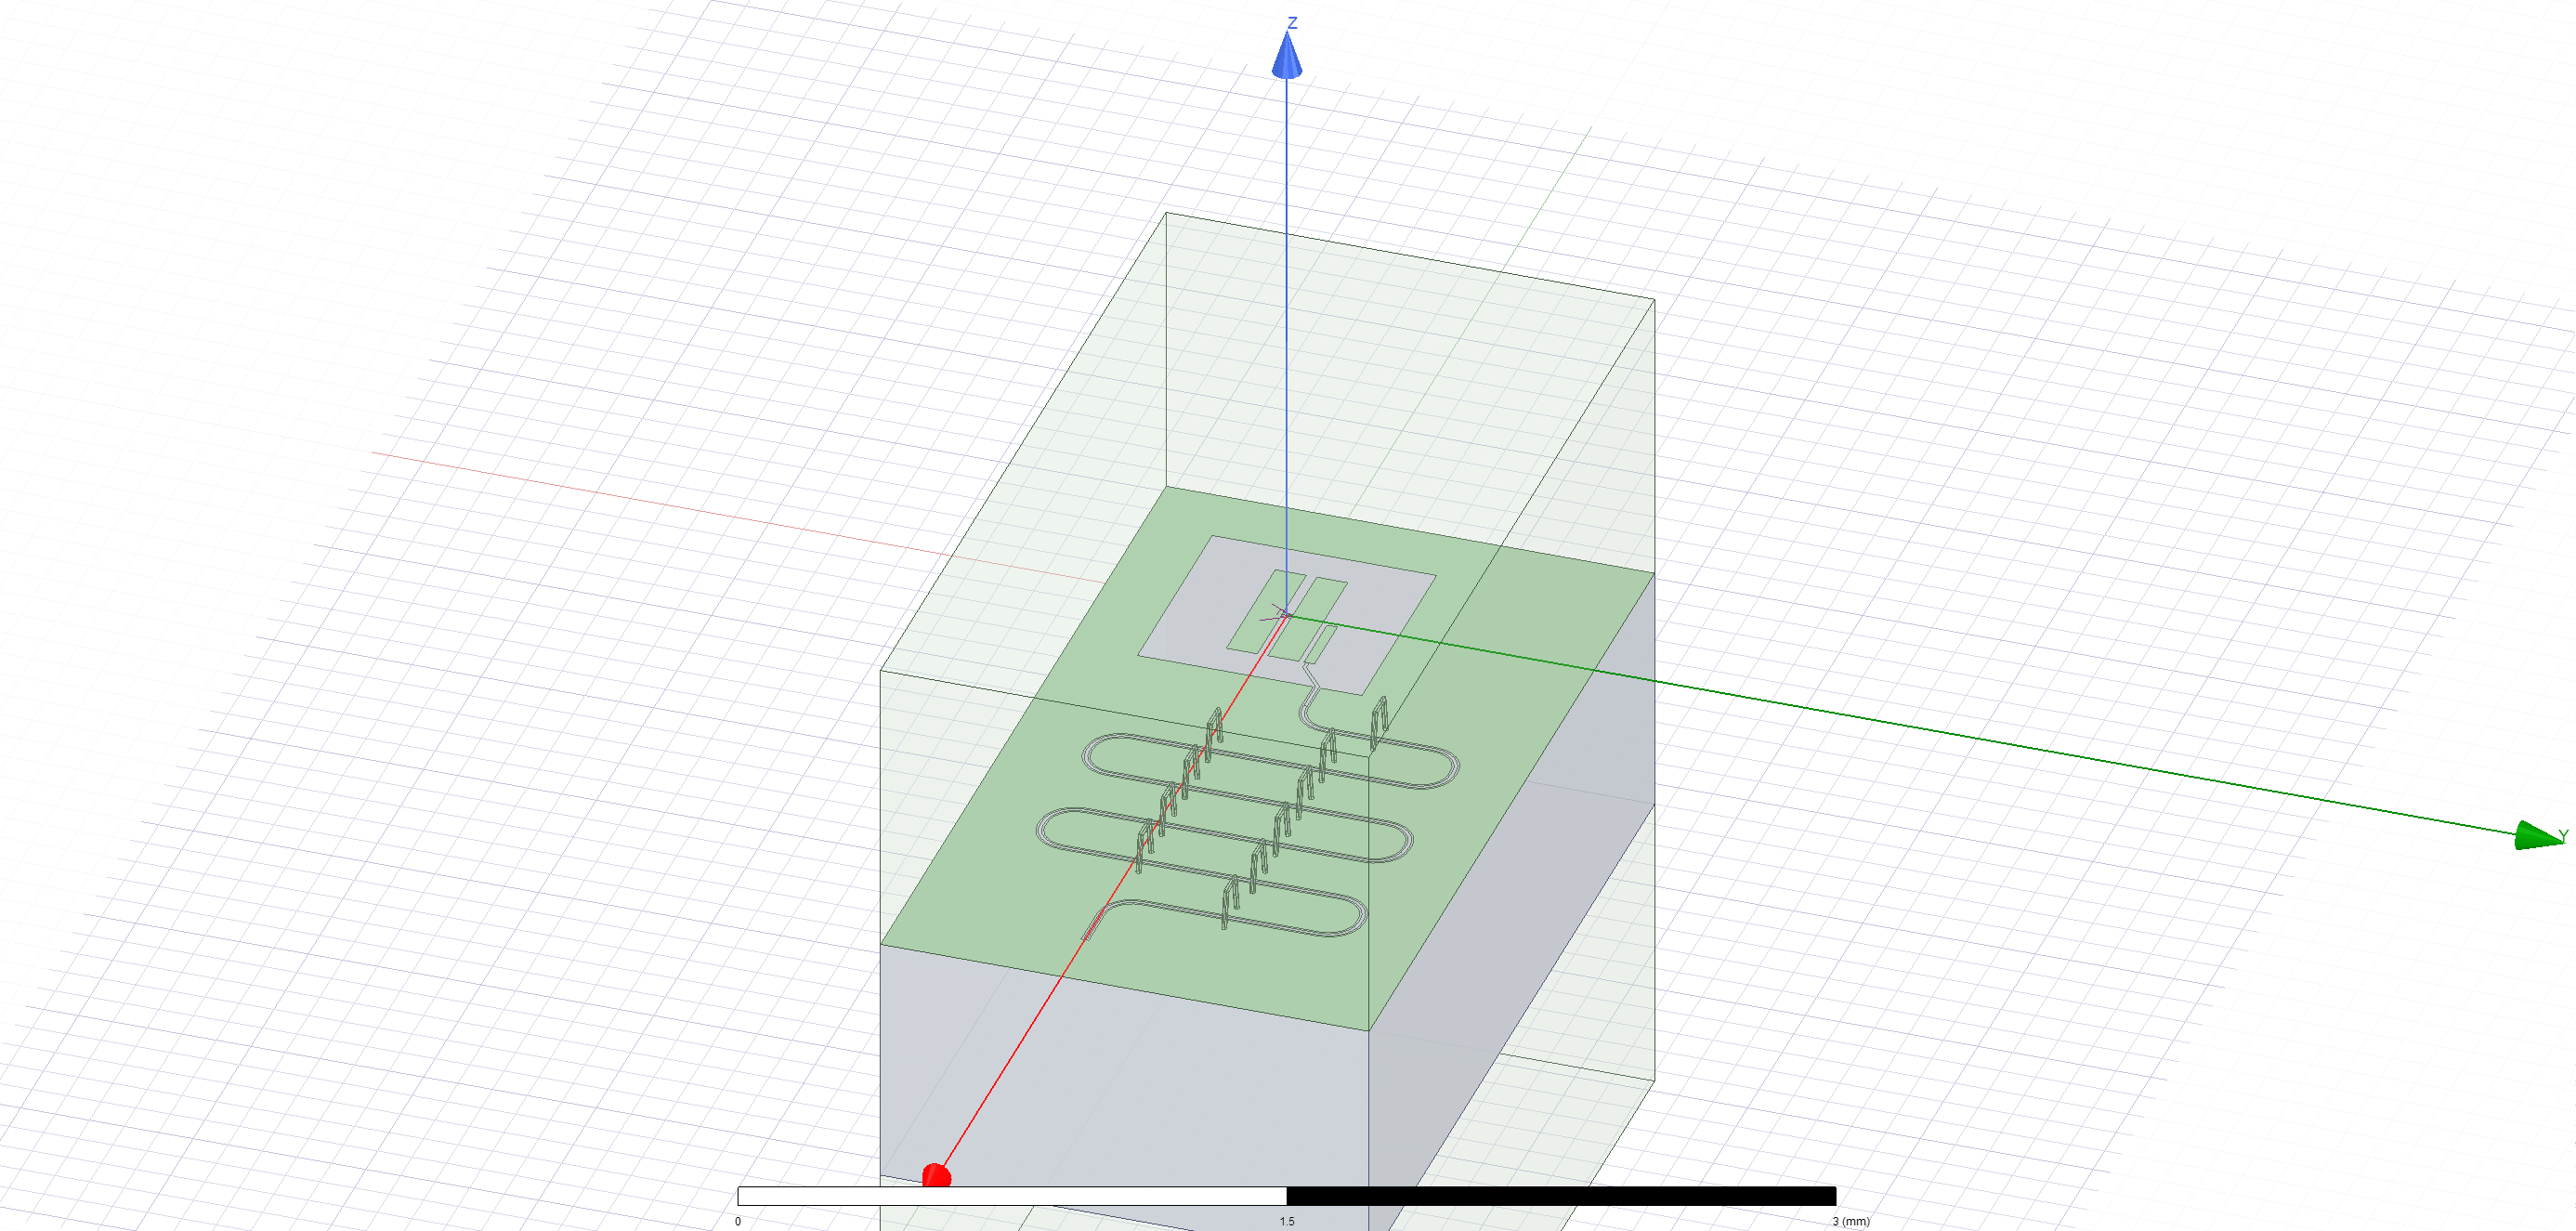

In [9]:
hfss.render_design(['Q1', 'readout', 'open_to_ground'], [])
hfss.save_screenshot()

Set the convergence parameters and junction properties in the Ansys design. Then run the analysis and plot the convergence. Note that we seek 2 eigenmodes - one with stronger fields near the transmon, the other with stronger fields near the resonator.

In [10]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 20
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 11:45AM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 20
Convergence freq max delta percent diff  = 0.1



12:20PM 17s INFO [hfss_report_f_convergence]: Saved convergences to C:\workspace\qiskit-metal\docs\tut\analysis\hfss_eig_f_convergence.csv


### Plot fields and display them
Display the Ansys modeler window and plot the E-field on the chip's surface.

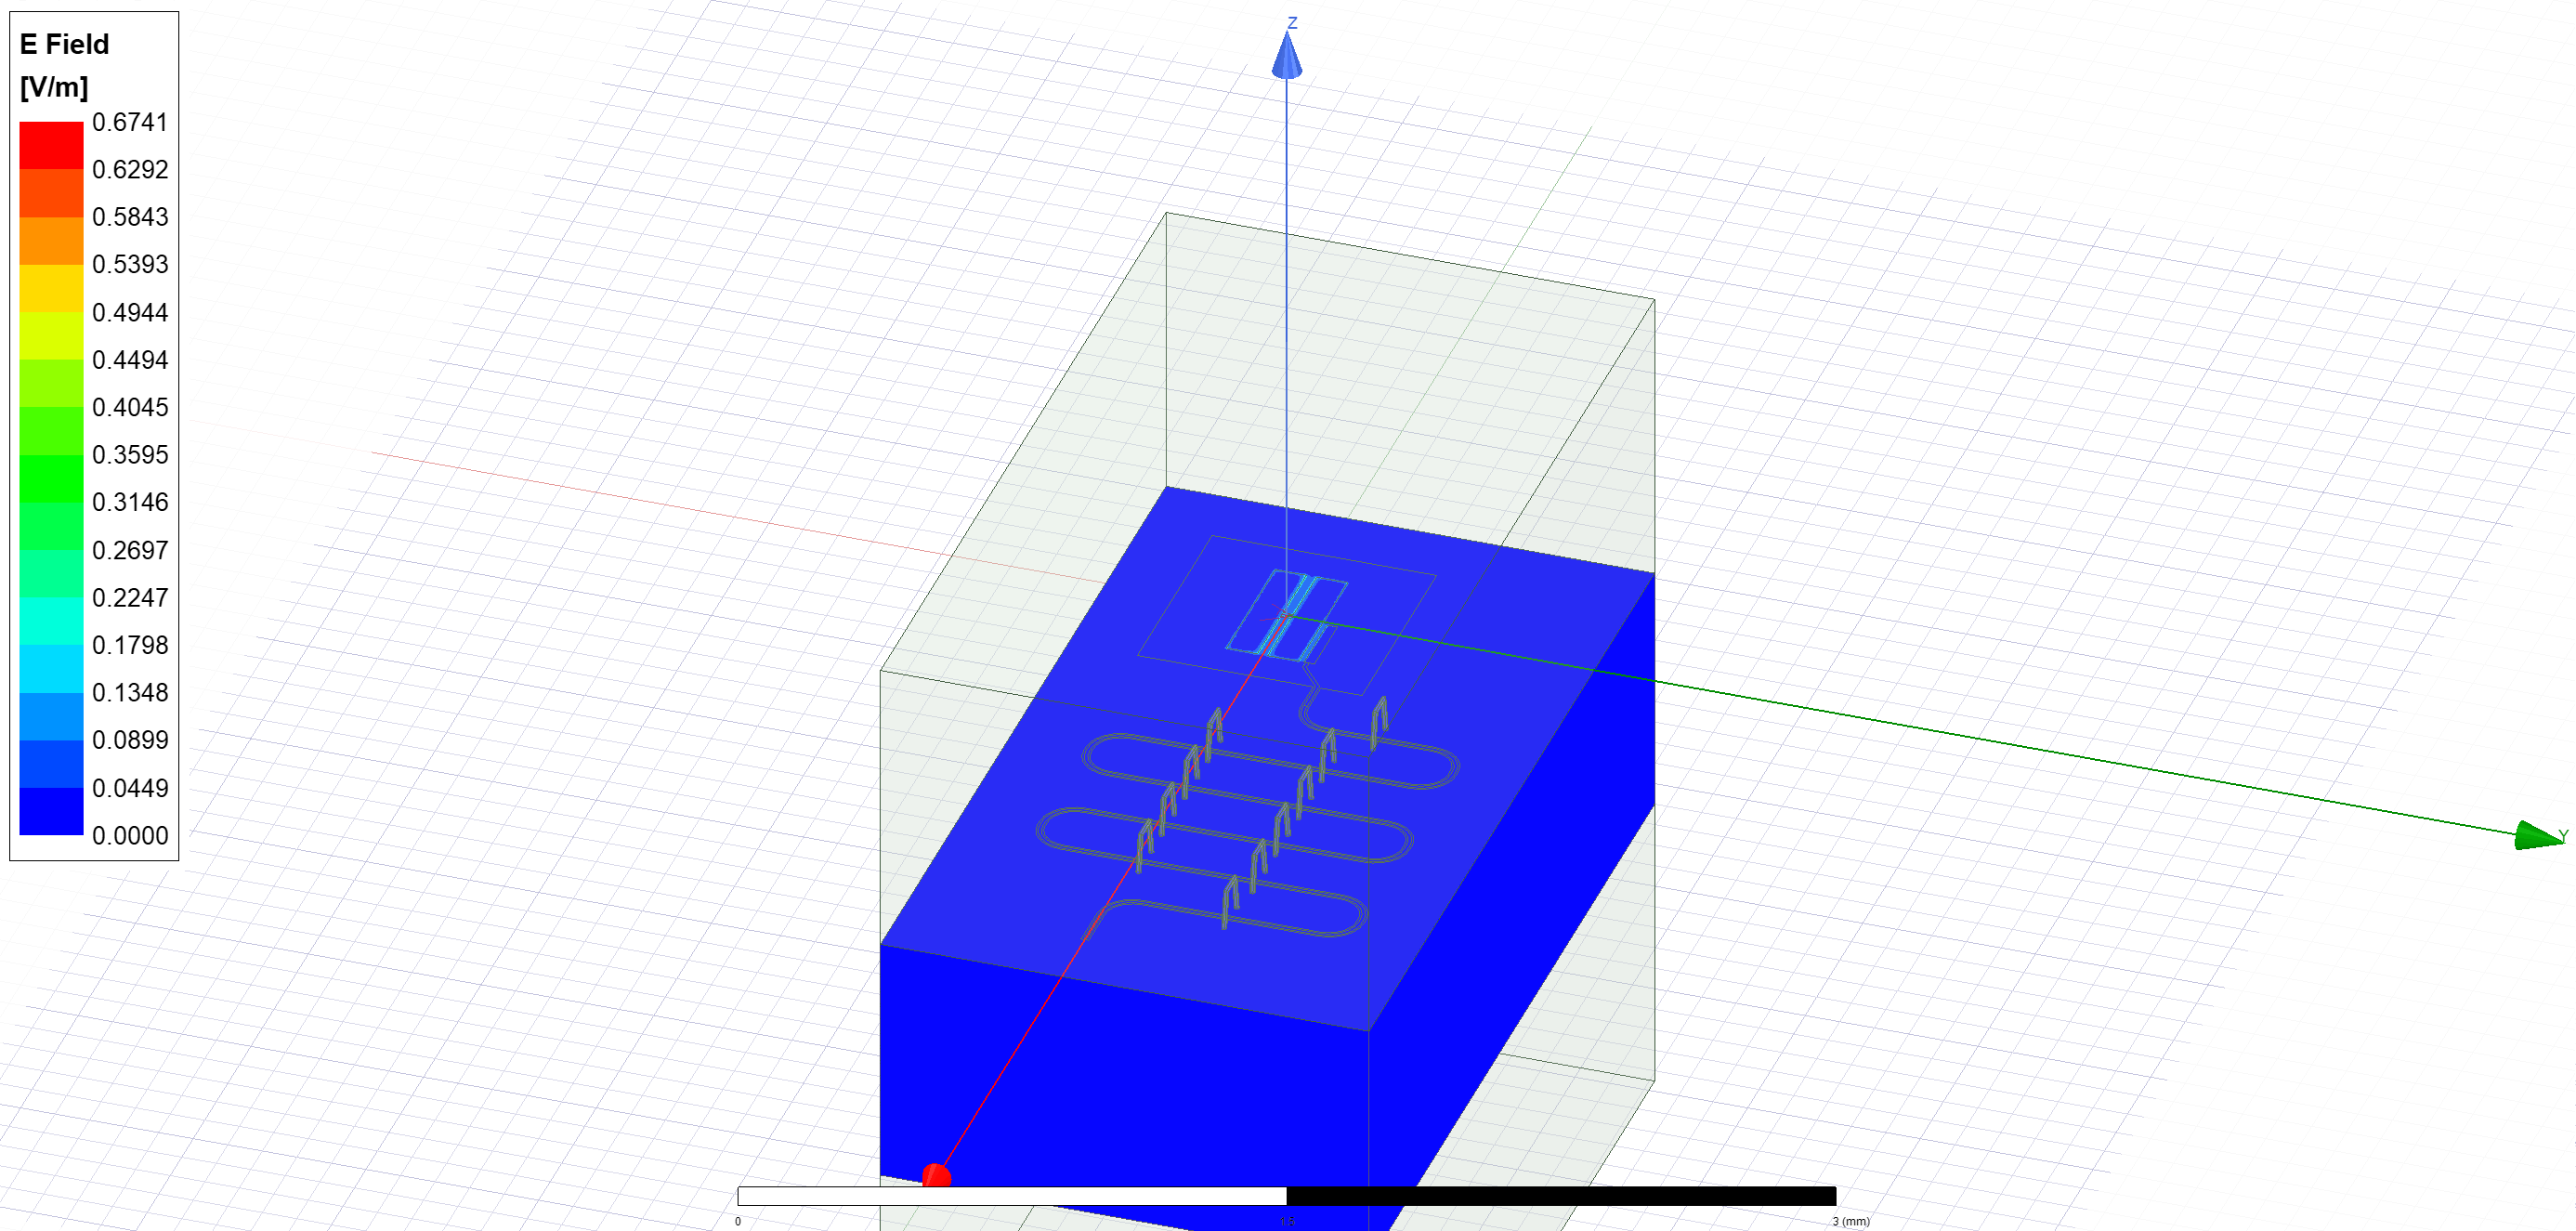

WindowsPath('C:/workspace/qiskit-metal/docs/tut/analysis/ansys.png')

In [11]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

Delete the newly created E-field plot before moving on.

In [12]:
hfss.plot_ansys_delete(['Mag_E1'])

To look at the second eigenmode created, we use the following command, and then plot the corresponding E-field.

In [13]:
hfss.set_mode(2, "Setup")

INFO 12:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


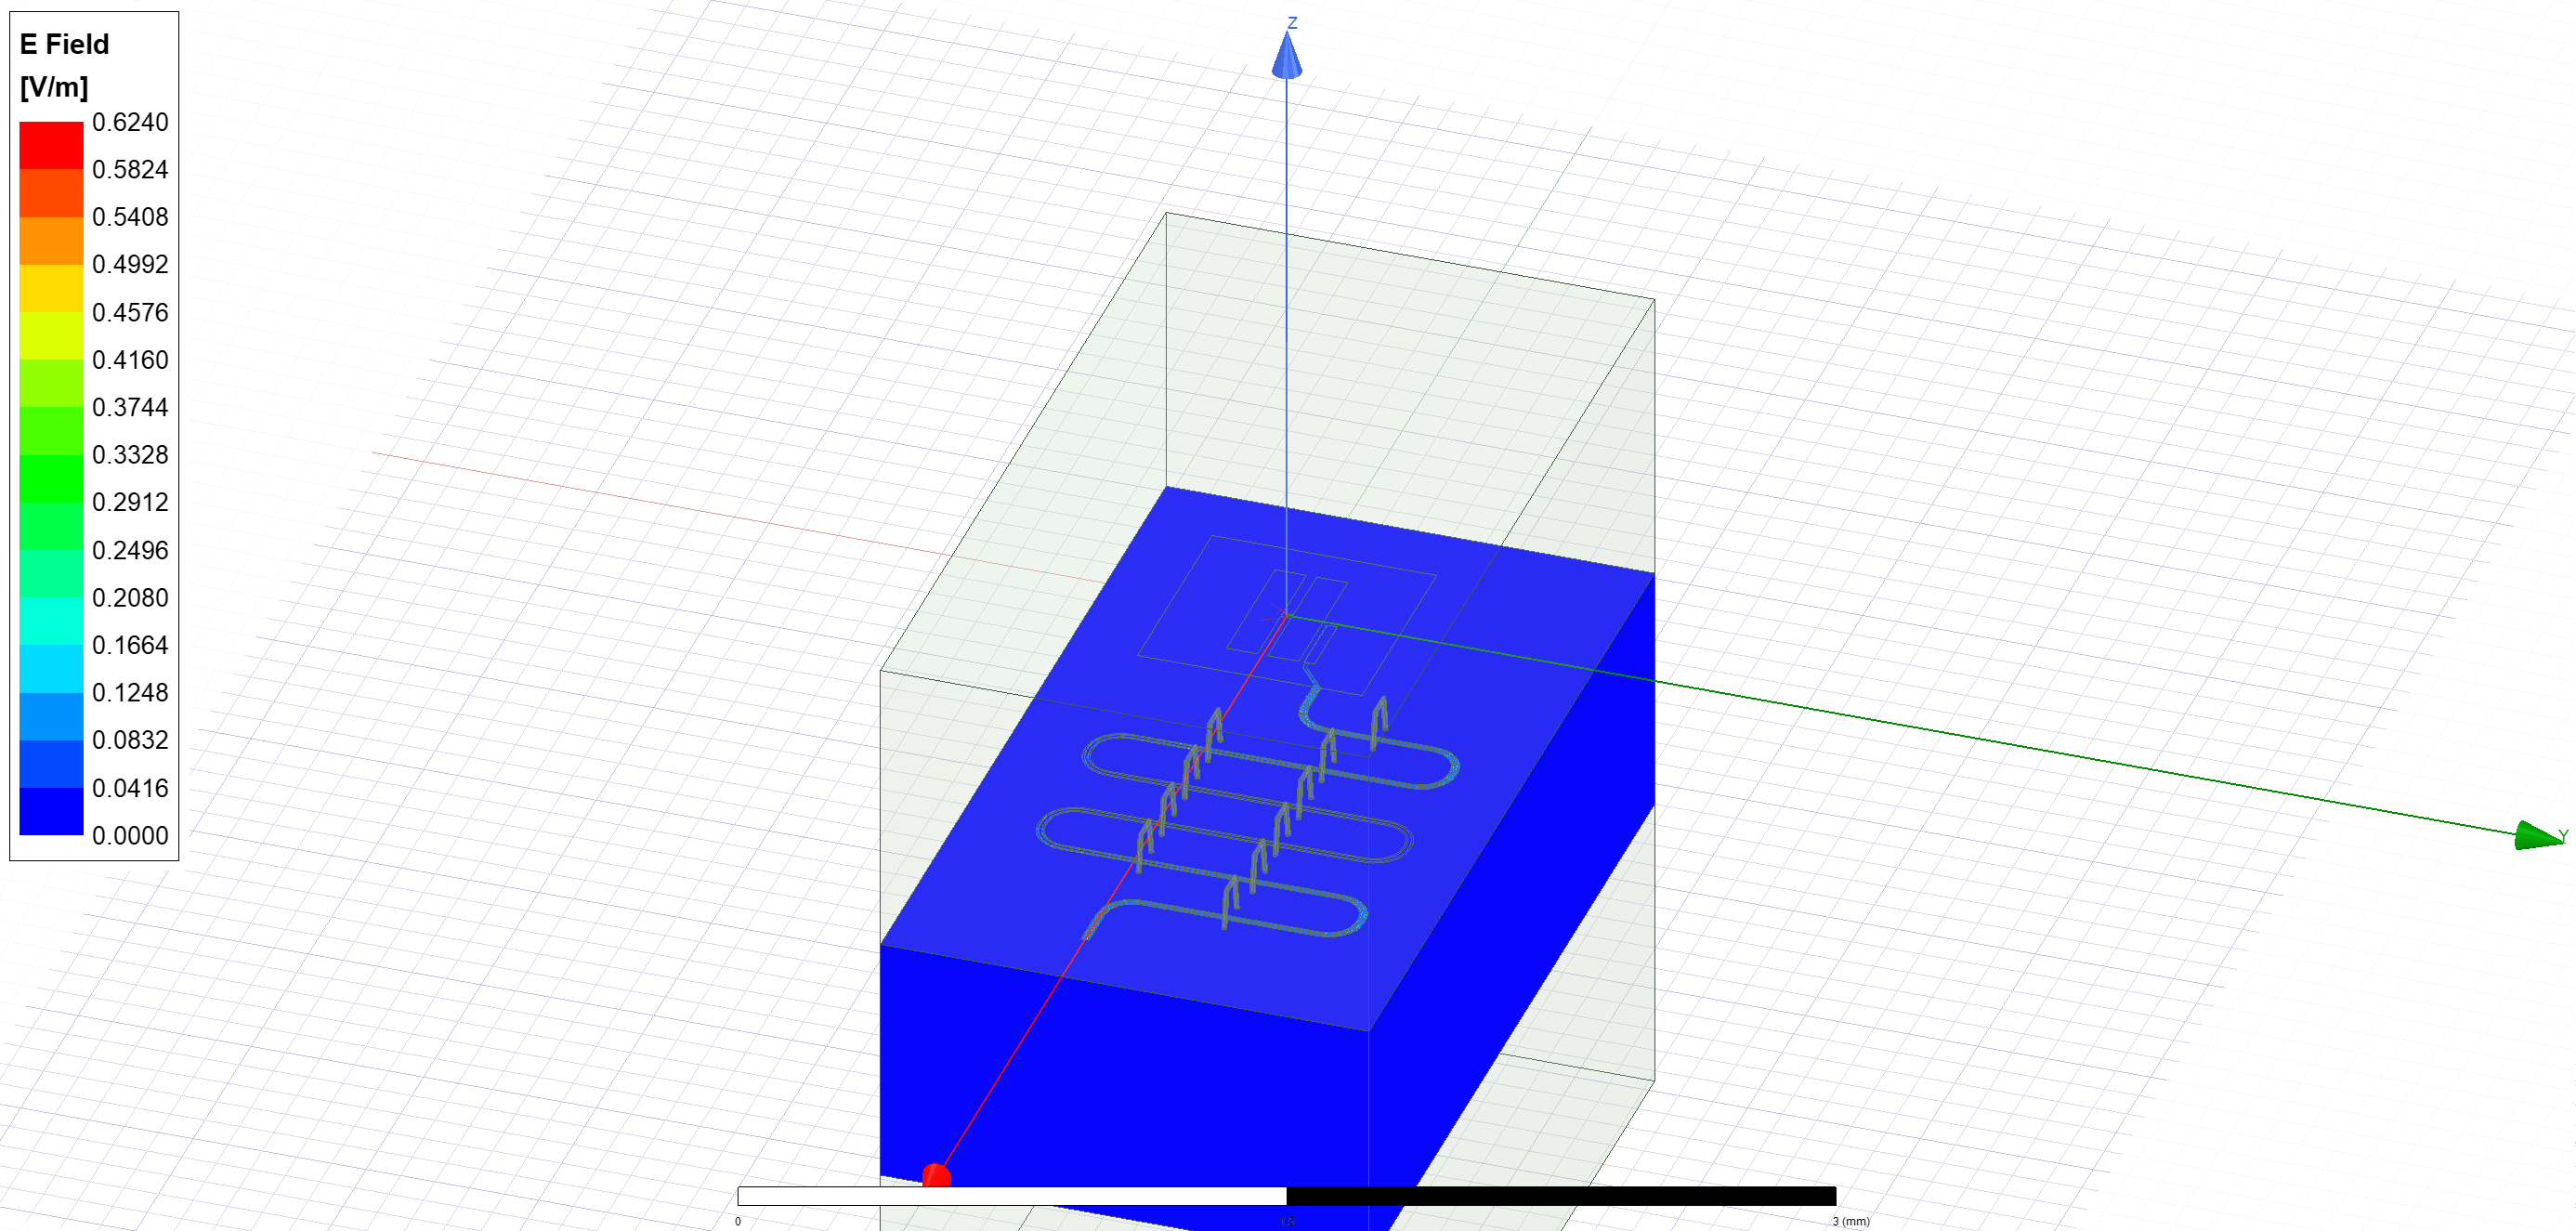

WindowsPath('C:/workspace/qiskit-metal/docs/tut/analysis/ansys.png')

In [14]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

We delete this design to prepare for further analysis.

In [15]:
hfss.plot_ansys_delete(['Mag_E1'])

In [16]:
%metal_print Energy-Participation-Ratio Analysis

### Set up EPR parameters
Specify the junctions in the model; in this case there's only one, namely 'jj'.

In [17]:
#Non-linear (Josephson) junction
pinfo = hfss.pinfo # Project info
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj', 
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify
# Handles  microwave analysis on eigenmode solutions
eprd = epr.DistributedAnalysis(pinfo)

Design "TransmonReadout" info:
	# eigenmodes    2
	# variations    1


Find the electric and magnetic energy stored in the substrate and the system as a whole.

In [18]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")


ℰ_elec_all       = 2.16839879329686e-25
ℰ_elec_substrate = 1.99721473482792e-25
EPR of substrate = 92.1%

ℰ_mag_all       = 2.16137805166233e-25
ℰ_mag % of ℰ_elec_all  = 99.7%



### Run EPR analysis

Perform EPR analysis for all modes and variations.

In [19]:
eprd.do_EPR_analysis()

# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

# 4b. Report solved results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)


Variation 0  [1/1]

  Mode 0 at 6.37 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  2.176e-25 1.929e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.89%
	jj              0.990667  (+)        0.0317587
		(U_tot_cap-U_tot_ind)/mean=1.59%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9210809272093007

  Mode 1 at 9.37 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  1.084e-25 1.081e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 93.51%
	jj              0.00326178  (+)        0.000226349
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric

WARNING 12:22PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project10\TransmonReadout\2021-06-01 12-20-46.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.032387
1    1.031118
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  0.960173
1  0.003261

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
    0.0033

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       305     2.95
      2.95  0.00715

*** Chi matrix ND (MHz) 
       341     2.47
      2.47  0.00506

*** Frequencies O1 PT (MHz)
0    6065.394014
1    9373.419062
dtype: float64

*** Frequencies ND (MHz)
0    6048.659698
1    9373.487908
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,6065.39
1,9373.42


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj                    
10 0  340.59  2.47e+00
   1    2.47  5.06e-03

Release Ansys session

In [20]:
hfss.disconnect_ansys()

In [21]:
%metal_print Q3D Analysis

Next we will look at a lumped oscillator model (LOM) for the same design.

## Render to Ansys Q3D

In [22]:
q3d = design.renderers.q3d

Again, we establish a connection with Ansys and add design for analysis

In [23]:
q3d.connect_ansys()
q3d.activate_q3d_design("TransmonResonator_q3d")

INFO 12:22PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:22PM [load_ansys_project]: 	Opened Ansys App
INFO 12:22PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 12:22PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project10
INFO 12:22PM [connect_design]: 	Opened active design
	Design:    TransmonReadout [Solution type: Eigenmode]
INFO 12:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:22PM [connect]: 	Connected to project "Project10" and design "TransmonReadout" 😀 

12:22PM 07s WARNING [activate_q3d_design]: The name=TransmonResonator_q3d was not in active project.  A new design will be inserted to the project.  Names in active project are: 
['TransmonReadout'].  
INFO 12:22PM [connect_design]: 	Opened active design
	Design:    TransmonResonator_q3d [Solution type: Q3D]
WARNING 12:22PM [connect_setup]: 	No design setup detected.
WARNING 12:22PM [connect_setup]: 	Creating Q3D default se

Next, we render the exisitng design to Ansys Q3D for analysis. To ensure that the readout is insulated from the ground plane, we set the 'readout' pin of Q1 to have an open termination.

In [24]:
q3d.render_design(['Q1'], [('Q1','readout')])

## Use Ansys Q3D to obtain the capacitance matrix

In [25]:
#Analyze the default solution setup
q3d.analyze_setup("Setup")

INFO 12:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 12:22PM [analyze]: Analyzing setup Setup


For a transmon only case, we should see a 4x4 capacitance matrix, four conductors corresponding to two conducting pads, one connector pad, and the ground palne.

In [26]:
# Using the analysis results, get its capacitance matrix as a dataframe.
q3d.get_capacitance_matrix()

INFO 12:23PM [get_matrix]: Exporting matrix data to (C:\Local\Temp\tmpiohnj_k9.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False


,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
ground_main_plane,177.78538,-44.74611,-38.34722,-37.03041
pad_bot_Q1,-44.74611,82.84141,-32.48515,-2.30760
pad_top_Q1,-38.34722,-32.48515,93.38943,-19.67329
readout_connector_pad_Q1,-37.03041,-2.30760,-19.67329,60.14998


The optional keyword parameters of get_capacitance_matrix are given below: <br><br>
variation: str = '' <br>
solution_kind: str = 'AdaptivePass' <br>
pass_number: int = 3

In [27]:
# Run lumped oscillator model (LOM) simulations and save results in dict_lom.b
dict_lom = q3d.lumped_oscillator_vs_passes(12.31, 2, 1, 7.0, [], 9)
dict_lom

INFO 12:23PM [get_matrix]: Exporting matrix data to (C:\Local\Temp\tmpc4nahpfu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 12:23PM [get_matrix]: Exporting matrix data to (C:\Local\Temp\tmp96ay3c_a.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 12:23PM [get_matrix]: Exporting matrix data to (C:\Local\Temp\tmpxyssrbwf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 12:23PM [get_matrix]: Exporting matrix data to (C:\Local\Temp\tmpqi6uw8n4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False
INFO 12:23PM [get_matrix]: Exporting matrix data to (C:\Local\Temp\tmpcih0jwdi.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 5, False
INFO 12:23PM [get_matrix]: Exporting matrix data to (C:\Local\Temp\tmprdqkdddr.txt, C, , Setup:AdaptivePass, "

[1, 2] [3]
Predicted Values

Transmon Properties
f_Q 5.508895 [GHz]
EC 322.410099 [MHz]
EJ 13.273404 [GHz]
alpha -377.222089 [MHz]
dispersion 62.166575 [KHz]
Lq 12.305036 [nH]
Cq 60.079471 [fF]
T1 46.068191 [us]

**Coupling Properties**

tCqbus1 -7.486202 [fF]
gbus1_in_MHz -118.930498 [MHz]
χ_bus1 -3.900791 [MHz]
1/T1bus1 3454.768693 [Hz]
T1bus1 46.068191 [us]
Bus-Bus Couplings


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.848077,366.598874,13.273404,-435.018704,183.524692,[-120.90670176407029],[-7.037262053035844],7.037262,120.906702
2,5.800483,360.198512,13.273404,-426.553995,158.893605,[-112.5714316750082],[-5.610863434477983],5.610863,112.571432
3,5.728978,350.706154,13.273404,-414.05886,127.373567,[-114.4721344200509],[-5.135837723457538],5.135838,114.472134
4,5.645726,339.839946,13.273404,-399.840701,97.757395,[-113.75236108111946],[-4.422671613573481],4.422672,113.752361
5,5.574615,330.715418,13.273404,-387.971176,77.483483,[-115.42485160814473],[-4.067027529550902],4.067028,115.424852
6,5.552051,327.850119,13.273404,-384.256913,71.883362,[-116.90656488361248],[-4.027920633490058],4.027921,116.906565
7,5.522295,324.093652,13.273404,-379.396816,65.050231,[-118.53068129631139],[-3.9548493935622147],3.954849,118.530681
8,5.508895,322.410099,13.273404,-377.222089,62.166575,[-118.93049750280109],[-3.9007913880708722],3.900791,118.930498


Using capacitance matrices obtained from each pass, save the many parameters of the Hamiltonian of the system. lumped_oscillator_vs_passes takes in the following parameters: <br><br>
Lj_nH: float <br>
Cj_fF: float <br>
N: int <br>
fr: Union[list, float] <br>
fb: Union[list, float] <br>
maxPass: int <br>
variation: str = '' <br>
solution_kind: str = 'AdaptivePass' <br>
g_scale: float = 1

Here,<br>
Lj - the Josephson inductance of your Josephson junction <br>
Cj - the capacitance of your Josephson junction<br>
N - the total number of connection pads <br>
fr - the frequency of the readout resonator <br>
[fb1, fb2, fb3...., fbN-1] - list of the frequencies of the busses<br>
passes - the number of passes your simulation ran for

dist_analysis allows one to calculate dissipation and other properties. It is used for the convergence plots below.

In [28]:
q3d.plot_convergence_main(dict_lom);
q3d.plot_convergence_chi(dict_lom)

INFO 12:23PM [hfss_report_full_convergence]: Creating report for variation 0


Design "TransmonResonator_q3d" info:
	# eigenmodes    0
	# variations    1


<Figure size 2970x1155 with 2 Axes>

In [29]:
q3d.disconnect_ansys()

In [30]:
gui.main_window.close()

True